## Detailed article explaination
The detailed code explanation for this article is available at the following link:

https://www.daniweb.com/programming/computer-science/tutorials/541531/extract-tabular-data-from-pdf-images-using-hugging-face-table-transformer

For my other articles for Daniweb.com, please see this link:

https://www.daniweb.com/members/1235222/usmanmalik57

## Installing and Importing Required Libraries

In [1]:
!pip install transformers
!sudo apt install tesseract-ocr
!pip install pytesseract
!pip install easyocr
!sudo apt-get install -y poppler-utils
!pip install pdf2image
!wget "https://fonts.google.com/download?family=Roboto" -O roboto.zip
!unzip roboto.zip -d ./roboto

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 35 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 1s (3,346 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debc

In [2]:
from transformers import AutoImageProcessor, TableTransformerForObjectDetection
import torch
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import csv
import numpy as np
import pandas as pd
from pdf2image import convert_from_path
from tqdm.auto import tqdm
import pytesseract
import easyocr

## Part 1 - Table Detection with Table Transformer

### Importing and Converting PDF to Image

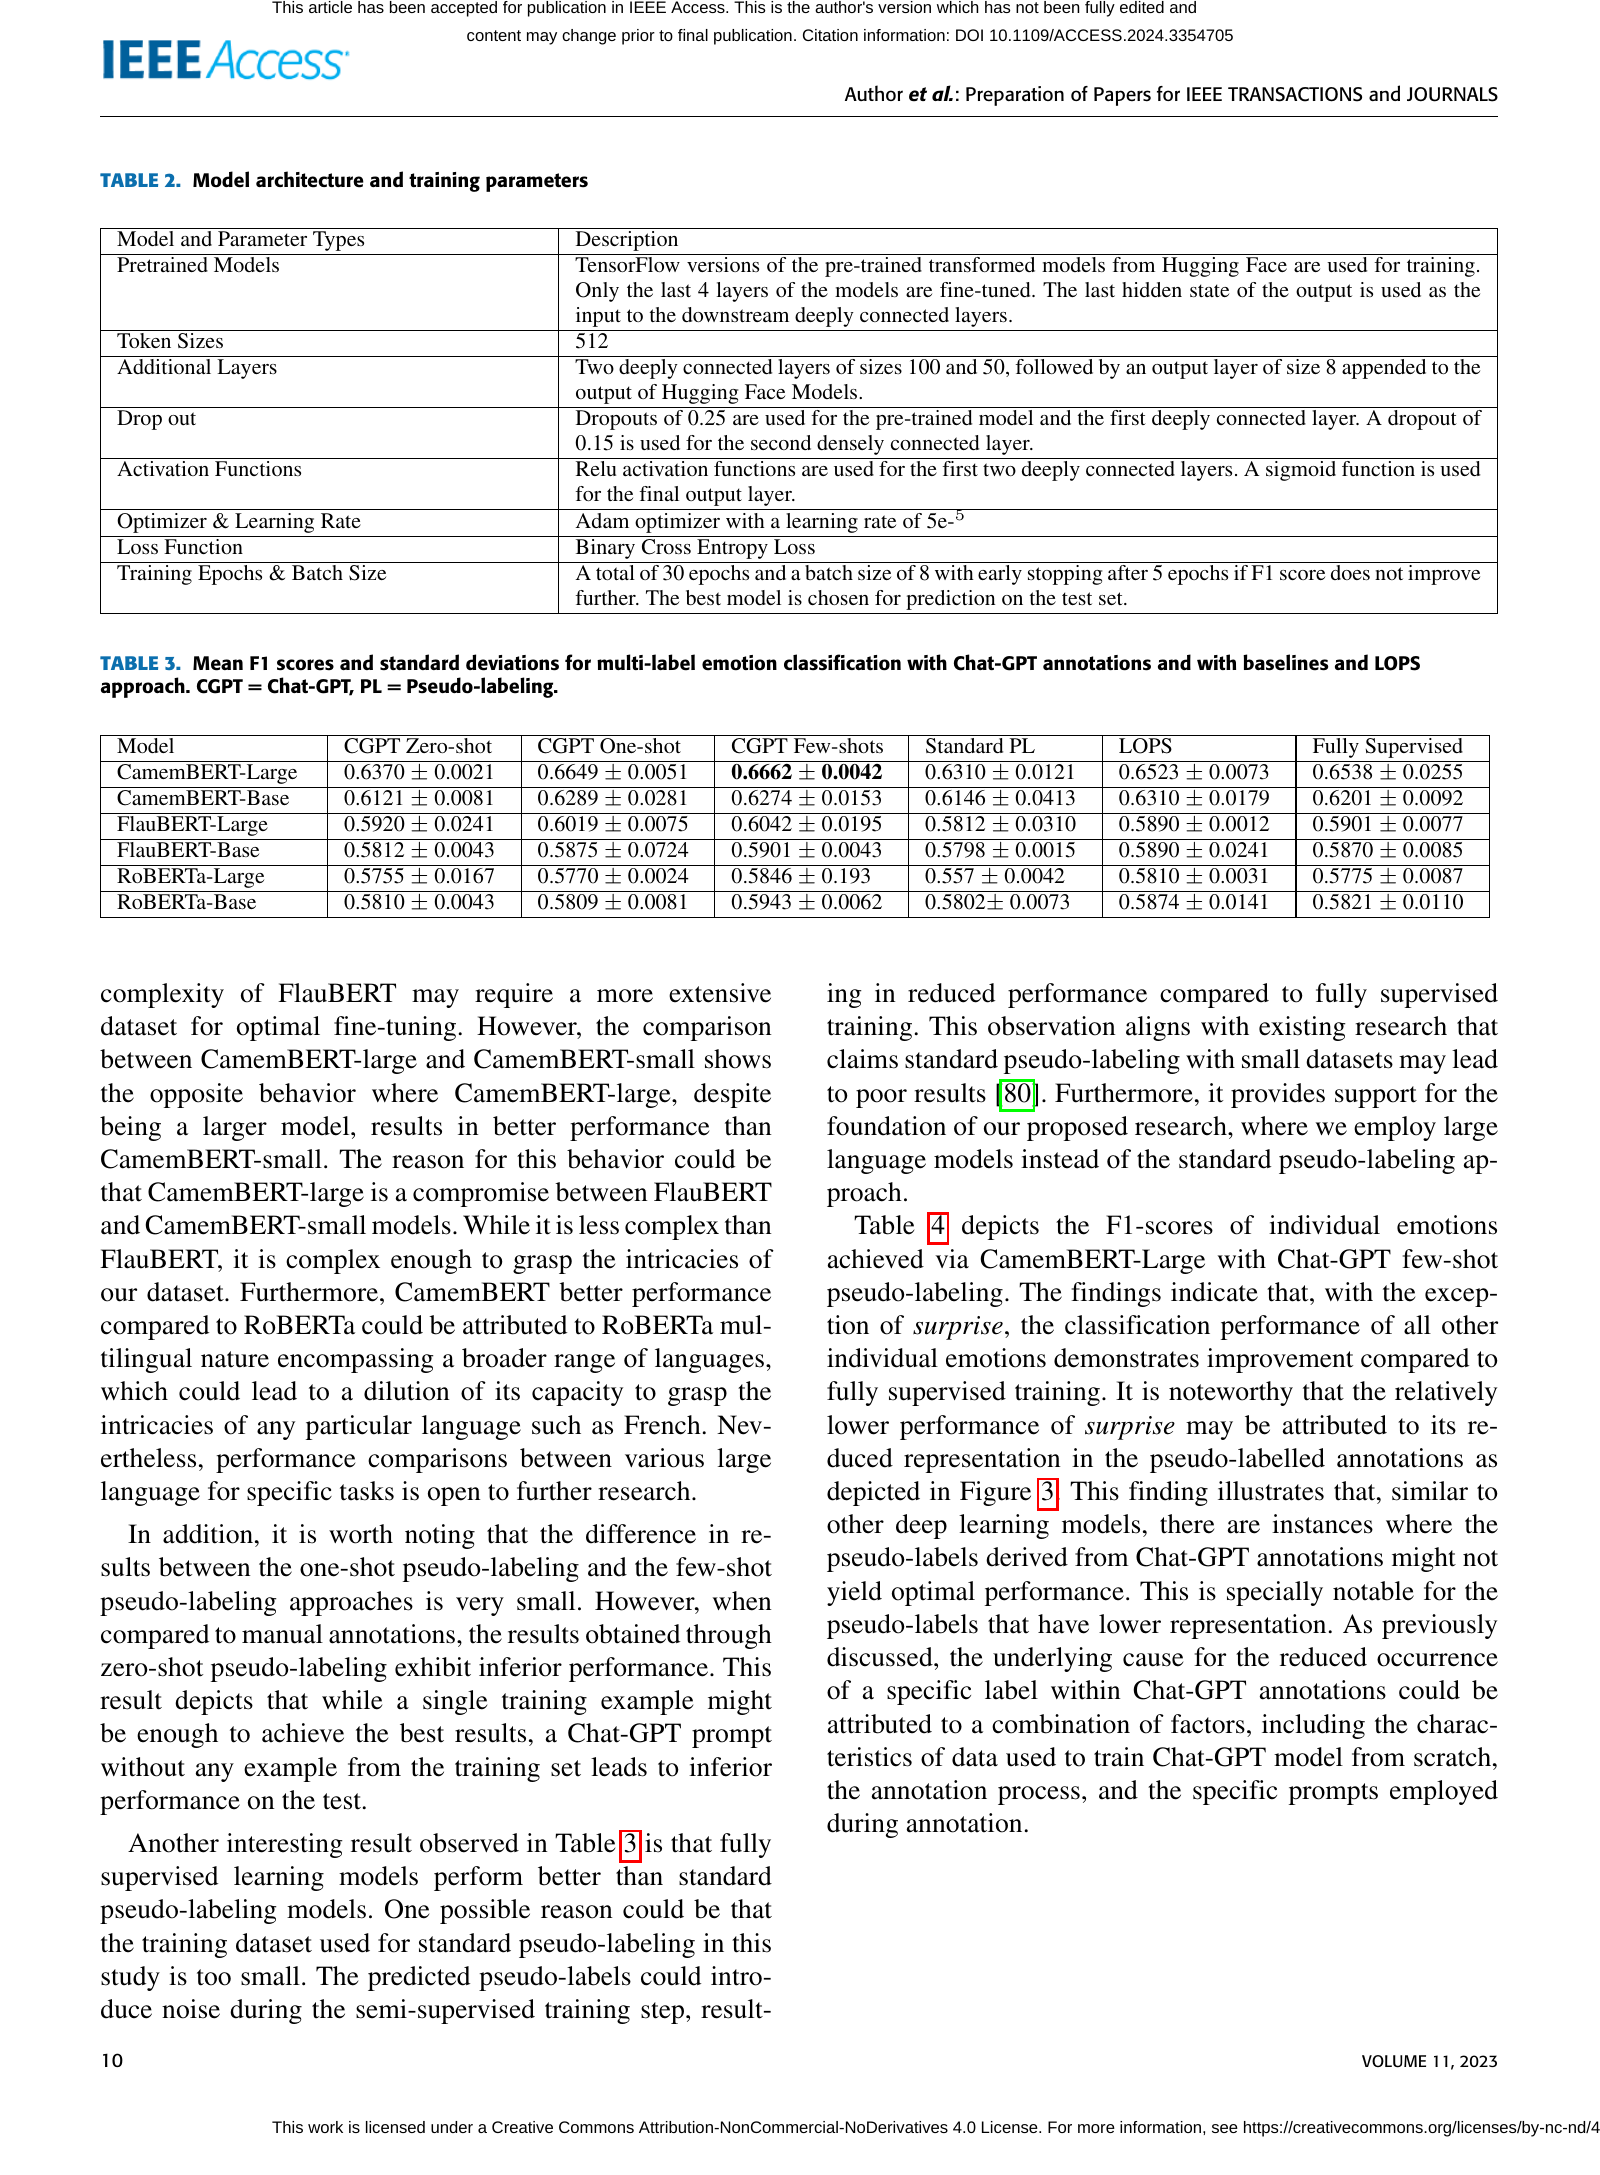

In [3]:
# convert PDF to Image
def pdf_to_img(image_path):

  image = convert_from_path(pdf_path)[0].convert("RGB")
  return image

pdf_path = '/content/sample_input_ieee-10.pdf'
image = pdf_to_img(pdf_path)
image

### Detect Tables

In [8]:
model_name = "microsoft/table-transformer-detection"
# define image preprocessor for table transformer
image_processor = AutoImageProcessor.from_pretrained(model_name)

# import table transformer model for table detection
model = TableTransformerForObjectDetection.from_pretrained(model_name,
                                                           revision="no_timm")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


In [9]:
def detect_table(image_doc):

  # preproces image document
  inputs = image_processor(images = image_doc, return_tensors="pt")

  # detect tables
  outputs = model(**inputs)

  # convert outputs (bounding boxes and class logits) to Pascal VOC format (xmin, ymin, xmax, ymax)
  target_sizes = torch.tensor([image_doc.size[::-1]])
  results = image_processor.post_process_object_detection(outputs,
                                                          threshold=0.9,
                                                          target_sizes=target_sizes)[0]

  return results

In [10]:

results = detect_table(image)
results

{'scores': tensor([0.9993, 0.9996], grad_fn=<IndexBackward0>),
 'labels': tensor([0, 0]),
 'boxes': tensor([[ 111.4175,  232.4397, 1481.5710,  606.8784],
         [ 110.4231,  738.1602, 1471.6283,  916.2267]],
        grad_fn=<IndexBackward0>)}

In [11]:
def get_table_bbox(results):

  tables_coordinates = []

  # iterate through all the detected table data
  for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]

    # store bbox coodinates in Pascal VOC format for later use
    table_dict = {"xmin" : box[0],
                  "ymin" : box[1],
                  "xmax" : box[2],
                  "ymax" : box[3]}

    tables_coordinates.append(table_dict)

    # print prediction label, prediction confidence score, and bbox values
    print(
        f"Detected {model.config.id2label[label.item()]} with confidence "
        f"{round(score.item(), 3)} at location {box}"
        )

  return tables_coordinates

In [12]:
table_bbox = get_table_bbox(results)

Detected table with confidence 0.999 at location [111.42, 232.44, 1481.57, 606.88]
Detected table with confidence 1.0 at location [110.42, 738.16, 1471.63, 916.23]


### Display Tables

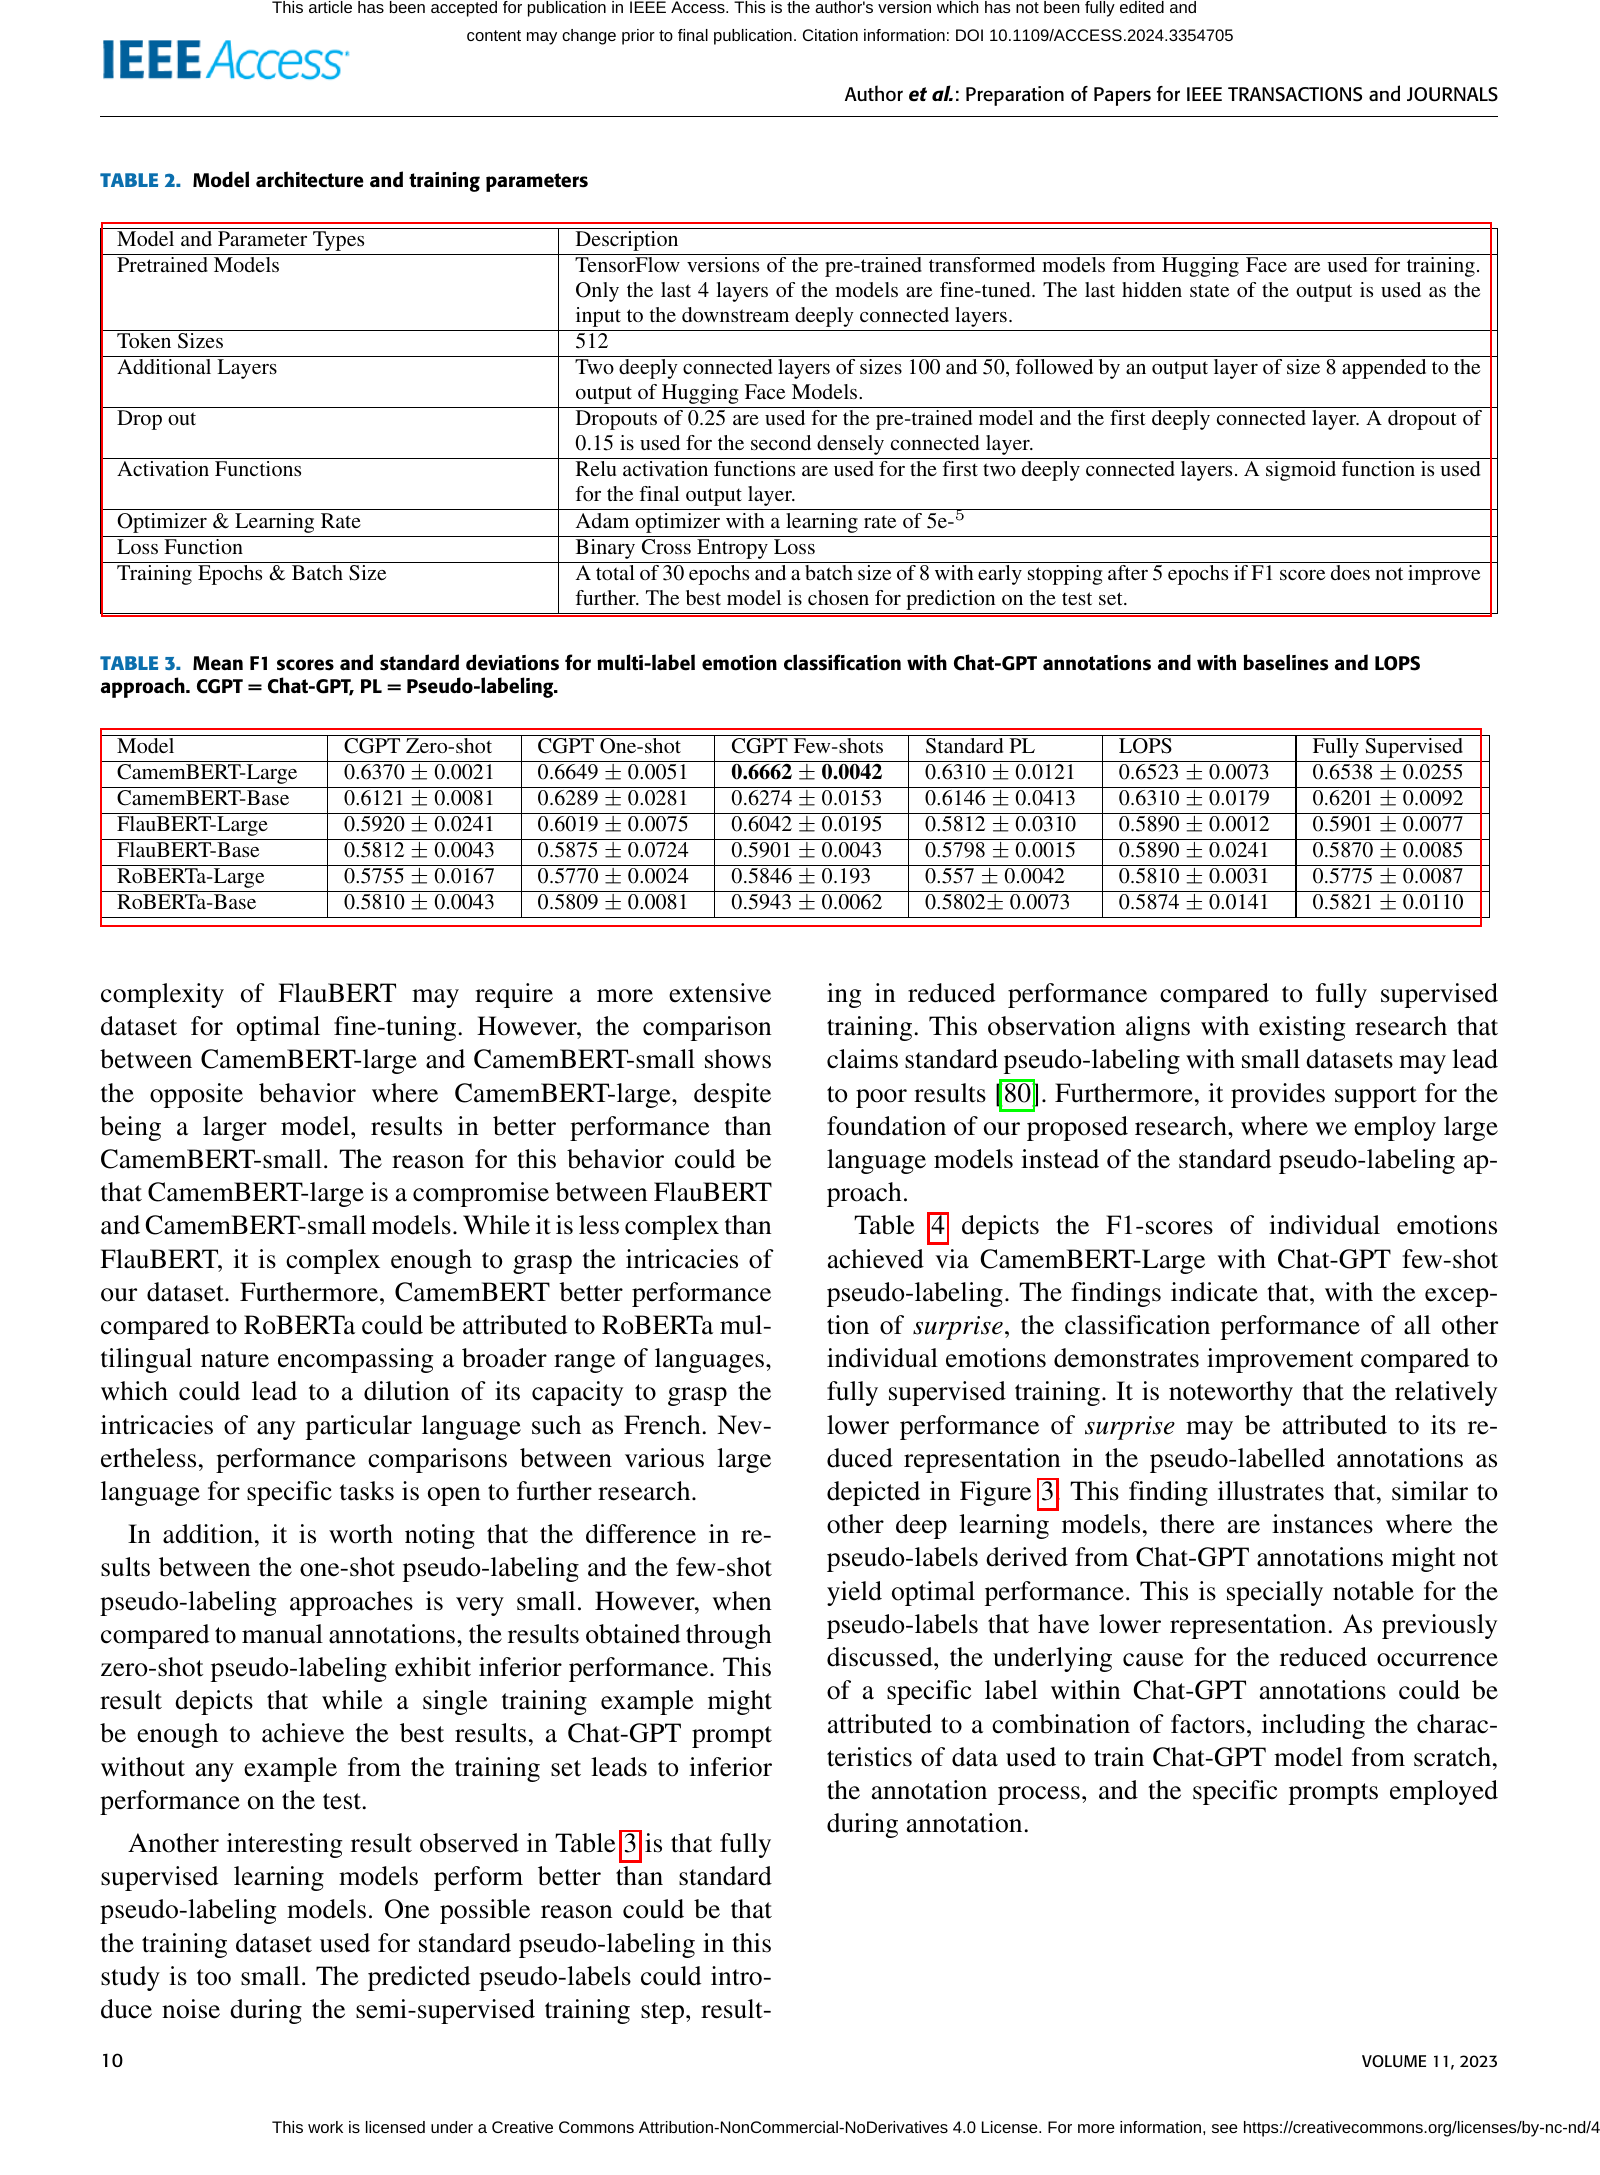

In [15]:
def highlight_tables(image, table_bbox, padding):
    # Create a drawing context for doc image
    doc_image = image.copy()
    draw = ImageDraw.Draw(doc_image)

    # Iterate over each table in the list
    for table in table_bbox:
        # Define the coordinates for the rectangle with padding for each table
        rectangle_coords = (table["xmin"] - padding,
                            table["ymin"] - padding,
                            table["xmax"] + padding,
                            table["ymax"] + padding)

        # Draw a red rectangle around the detected table
        draw.rectangle(rectangle_coords, outline="red", width=2)

    return doc_image

padding = 10
table_detected_image = highlight_tables(image, table_bbox, padding)
table_detected_image

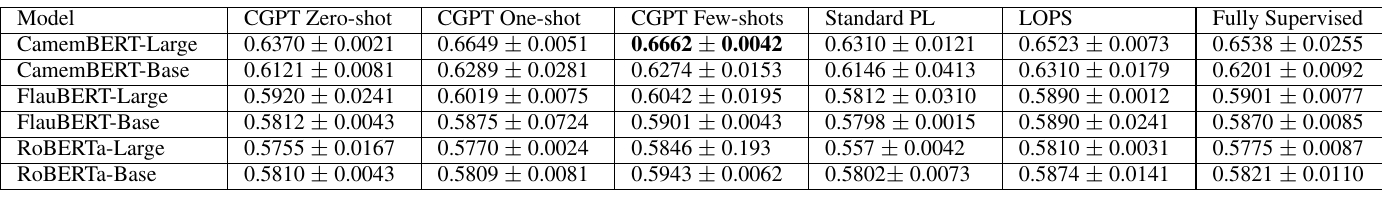

In [20]:
def get_cropped_image(image, table, padding):
  # Create a new image object with the cropped area
  cropped_image = image.copy().crop((table["xmin"] -padding,
                             table["ymin"] - padding,
                             table["xmax"] + padding,
                             table["ymax"] + padding
                             ))

  return cropped_image

cropped_image = get_cropped_image(image, table_bbox[1], padding)
cropped_image

## Part 2 - Extract Table Data

### Extract Table Features

In [21]:
# import model for detecting table features e.g. rows, columns, etc
structure_model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-structure-recognition-v1.1-all")

config.json:   0%|          | 0.00/76.8k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

In [41]:
def get_table_features(cropped_image):

  # preprocess image input for table transformer
  inputs = image_processor(images = cropped_image, return_tensors="pt")

  # make prediction using table transformer
  outputs = structure_model(**inputs)

  # post process output to Pasval VOC bbox format
  target_sizes = torch.tensor([cropped_image.size[::-1]])
  results = image_processor.post_process_object_detection(outputs, threshold=0.9, target_sizes=target_sizes)[0]

  # define a list to store detected features
  features = []

  # iterate through all the detected features and store feature label, confidence score, and bbox values to cells list
  for i, (score, label, box) in enumerate(zip(results["scores"], results["labels"], results["boxes"])):
      box = [round(i, 2) for i in box.tolist()]
      score = score.item()
      label = structure_model.config.id2label[label.item()]

      cell_dict = {"label":label,
                  "score":score,
                  "bbox":box
                  }


      # print table features
      features.append(cell_dict)
      print(
          f"Detected {label} with confidence "
          f"{round(score, 3)} at location {box}"
      )

  return features


features = get_table_features(cropped_image)

Detected table column with confidence 1.0 at location [218.46, 2.72, 414.69, 184.15]
Detected table column with confidence 1.0 at location [997.59, 2.59, 1188.88, 184.09]
Detected table column with confidence 1.0 at location [804.63, 2.5, 995.39, 184.06]
Detected table row with confidence 0.999 at location [13.8, 27.8, 1363.56, 54.06]
Detected table column with confidence 1.0 at location [1190.71, 2.61, 1363.62, 184.09]
Detected table column header with confidence 0.996 at location [13.86, 2.72, 1363.47, 27.93]
Detected table row with confidence 0.999 at location [13.52, 53.45, 1363.88, 79.55]
Detected table row with confidence 1.0 at location [13.78, 132.34, 1363.76, 158.05]
Detected table column with confidence 1.0 at location [416.81, 2.65, 607.56, 184.15]
Detected table row with confidence 0.999 at location [14.13, 80.27, 1363.54, 106.53]
Detected table with confidence 1.0 at location [13.41, 2.54, 1363.72, 184.05]
Detected table row with confidence 1.0 at location [13.37, 158.71, 

### Display Detected Features

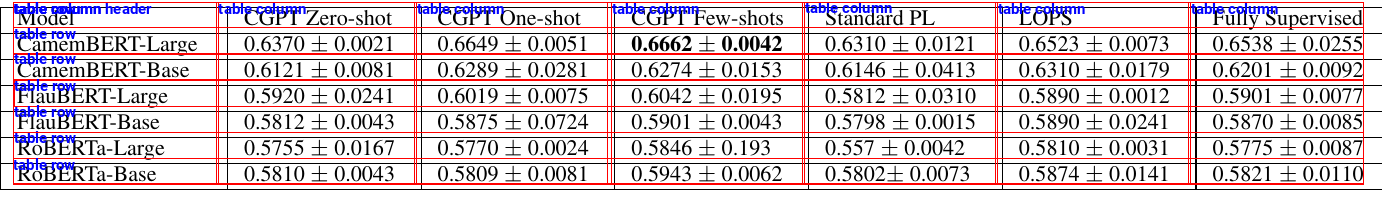

In [43]:
def display_detected_features(cropped_image, features):

  cropped_table_visualized = cropped_image.copy()
  draw = ImageDraw.Draw(cropped_table_visualized)

  # increase font size for text labels
  font = ImageFont.truetype("/content/roboto/Roboto-Bold.ttf", 15)

  # iterate through all features and display bounding box with text labels
  for feature in features:
      draw.rectangle(feature["bbox"], outline="red")

      text_position = (feature["bbox"][0], feature["bbox"][1] - 3)

      draw.text(text_position, feature["label"], fill="blue", font = font)

  # return cropped image with bounding box
  return cropped_table_visualized

display_detected_features(cropped_image, features)

## Part 3 - Extract Cell Text Using OCR and Convert to CSV

### Extract Cell Coordinates

In [44]:
def get_cell_coordinates_by_row(table_data):
    # Extract rows and columns
    rows = [entry for entry in table_data if entry['label'] == 'table row']
    columns = [entry for entry in table_data if entry['label'] == 'table column']

    # Sort rows and columns by their Y and X coordinates, respectively
    rows.sort(key=lambda x: x['bbox'][1])
    columns.sort(key=lambda x: x['bbox'][0])

    # Function to find cell coordinates
    def find_cell_coordinates(row, column):
        cell_bbox = [column['bbox'][0], row['bbox'][1], column['bbox'][2], row['bbox'][3]]
        return cell_bbox

    # Generate cell coordinates and count cells in each row
    cell_coordinates = []

    for row in rows:
        row_cells = []
        for column in columns:
            cell_bbox = find_cell_coordinates(row, column)
            row_cells.append({'cell': cell_bbox})

        # Append row information to cell_coordinates
        cell_coordinates.append({'cells': row_cells, 'cell_count': len(row_cells)})


    return cell_coordinates

cell_coordinates = get_cell_coordinates_by_row(features)

### Extract Text from Cell Coordinates using OCR

In [46]:


def apply_ocr(cell_coordinates, cropped_image):
    # let's OCR row by row
    data = dict()
    max_num_columns = 0
    for idx, row in enumerate(tqdm(cell_coordinates)):
        row_text = []
        for cell in row["cells"]:
            # crop cell out of image
            cell_image = np.array(cropped_image.crop(cell["cell"]))

            # apply OCR using PyTesseract
            text = pytesseract.image_to_string(cell_image, lang='eng', config='--psm 6').strip()
            if text:
                row_text.append(text)


        if len(row_text) > max_num_columns:
            max_num_columns = len(row_text)

        data[idx] = row_text

    print("Max number of columns:", max_num_columns)

    # pad rows which don't have max_num_columns elements
    for row, row_data in data.copy().items():
        if len(row_data) != max_num_columns:
            row_data = row_data + ["" for _ in range(max_num_columns - len(row_data))]
        data[row] = row_data
        print(row_data)

    return data

data = apply_ocr(cell_coordinates, cropped_image)

  0%|          | 0/7 [00:00<?, ?it/s]

Max number of columns: 7
['Model', 'CGPT Zero-shot', 'CGPT One-shot', 'CGPT Few-shots', 'Standard PL', 'LOPS', 'Fully Supervised']
['CamemBERT-Large', '0.6370 + 0.0021', '0.6649 + 0.0051', '0.6662 + 0.0042', '0.6310 + 0.0121', '0.6523 + 0.0073', '0.6538 + 0.0255']
['CamemBERT-Base', '0.6121 + 0.0081', '0.6289 + 0.0281', '0.6274 + 0.0153', '0.6146 + 0.0413', '0.6310 + 0.0179', '0.6201 + 0.0092']
['FlauBERT-Large', '0.5920 + 0.0241', '0.6019 + 0.0075', '0.6042 + 0.0195', '0.5812 + 0.0310', '0.5890 + 0.0012', '0.5901 + 0.0077']
['FlauBERT-Base', '0.5812 + 0.0043', '0.5875 + 0.0724', '0.5901 + 0.0043', '0.5798 + 0.0015', '0.5890 + 0.0241', '0.5870 + 0.0085']
['RoBERTa-Large', '0.5755 + 0.0167', '0.5770 + 0.0024', '0.5846 + 0.193', '0.557 + 0.0042', '0.5810 + 0.0031', '0.5775 + 0.0087']
['RoBERTa-Base', '0.5810 + 0.0043', '0.5809 + 0.0081', '0.5943 + 0.0062', '0.5802+ 0.0073', '0.5874 + 0.0141', '0.5821 + 0.0110']


### Saving Content as CSV

In [47]:
def write_csv(data):

  with open('output.csv','w') as result_file:
      wr = csv.writer(result_file, dialect='excel')
      for row, row_text in data.items():

        wr.writerow(row_text)

write_csv(data)

df = pd.read_csv("output.csv")
df

,Model,CGPT Zero-shot,CGPT One-shot,CGPT Few-shots,Standard PL,LOPS,Fully Supervised
0,CamemBERT-Large,0.6370 + 0.0021,0.6649 + 0.0051,0.6662 + 0.0042,0.6310 + 0.0121,0.6523 + 0.0073,0.6538 + 0.0255
1,CamemBERT-Base,0.6121 + 0.0081,0.6289 + 0.0281,0.6274 + 0.0153,0.6146 + 0.0413,0.6310 + 0.0179,0.6201 + 0.0092
2,FlauBERT-Large,0.5920 + 0.0241,0.6019 + 0.0075,0.6042 + 0.0195,0.5812 + 0.0310,0.5890 + 0.0012,0.5901 + 0.0077
3,FlauBERT-Base,0.5812 + 0.0043,0.5875 + 0.0724,0.5901 + 0.0043,0.5798 + 0.0015,0.5890 + 0.0241,0.5870 + 0.0085
4,RoBERTa-Large,0.5755 + 0.0167,0.5770 + 0.0024,0.5846 + 0.193,0.557 + 0.0042,0.5810 + 0.0031,0.5775 + 0.0087
5,RoBERTa-Base,0.5810 + 0.0043,0.5809 + 0.0081,0.5943 + 0.0062,0.5802+ 0.0073,0.5874 + 0.0141,0.5821 + 0.0110
